# NAS für MedMNIST `CNN`
Dieses Notebook:
1. Erstellt Datenlader für MedMNIST (`pathmnist` oder `tissuemnist`)  
2. Definiert ein CNN-Modell  
3. Implementiert epochweise `train`- und `eval`-Schleifen  
4. Führt eine neuronale Architektursuche mit **Optuna** durch  
5. Trainiert die beste Konfiguration neu und speichert Logs und das Modell  
6. Zeichnet die epochale **Verlust/Genauigkeit** und eine **Cofusion Matrix** auf

In [24]:
import os, json, time, random
import numpy as np
import torch
import tqdm as notebook_tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from torch.utils.data import DataLoader, random_split
import seaborn as sns
from torchmetrics.classification import ConfusionMatrix
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

from medmnist import INFO, TissueMNIST, PathMNIST
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

import matplotlib.pyplot as plt

# Reproducibility
def set_seeds(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise RuntimeError("no cuda gpu found")
print("Device:", device)

Device: cuda


In [25]:
# CONFIG
CFG = {
    "dataset": "pathmnist",
    "img_size": 64,
    "batch": 64,
    "seed": 42,

    # Optuna search
    "trials": 30,          
    "epochs_trial": 8,     
    "retrain_epochs": 20,  
}

os.makedirs("outputs", exist_ok=True)
set_seeds(CFG["seed"])

In [26]:
def build_loaders(dataset_name: str, img_size: int, batch: int, seed: int):
    info = INFO[dataset_name]
    n_classes = len(info["label"])
    class_names = [str(k) for k in range(n_classes)] 
    n_channels = info["n_channels"]
    as_rgb = (n_channels == 3)

    mean = [0.5] * n_channels
    std  = [0.5] * n_channels

    train_tf = T.Compose([
        T.Resize((img_size, img_size)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    test_tf = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    DataSet = PathMNIST if dataset_name == "pathmnist" else TissueMNIST
    train_set = DataSet(split="train", download=True, transform=train_tf, as_rgb=as_rgb)
    test_set  = DataSet(split="test",  download=True, transform=test_tf, as_rgb=as_rgb)

    g = torch.Generator().manual_seed(seed)
    val_size = int(0.1 * len(train_set))
    train_set, val_set = random_split(train_set, [len(train_set)-val_size, val_size], generator=g)

    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True,  num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=batch, shuffle=False, num_workers=0, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch, shuffle=False, num_workers=0, pin_memory=True)

    return train_loader, val_loader, test_loader, n_channels, n_classes, class_names

In [ ]:
class StaticCNN(nn.Module):
    def __init__(self, in_ch, base_ch, mult4, kernel_size, pool_type, num_dense, dense_units, dropout, n_classes):
        super().__init__()
        k = kernel_size
        Pool = nn.MaxPool2d if pool_type == "max" else nn.AvgPool2d

        # Stage 1
        ch1 = base_ch
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_ch, ch1, k, padding=k//2, bias=False),
            nn.BatchNorm2d(ch1), nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(ch1, ch1, k, padding=k//2, bias=False),
            nn.BatchNorm2d(ch1), nn.ReLU(inplace=True),
            Pool(2)
        )

        # Stage 2
        ch4 = ch1 * mult4
        self.layer3 = nn.Sequential(
            nn.Conv2d(ch1, ch4, k, padding=k//2, bias=False),
            nn.BatchNorm2d(ch4), nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(ch4, ch4, k, padding=k//2, bias=False),
            nn.BatchNorm2d(ch4), nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(ch4, ch4, k, padding=k//2, bias=False),
            nn.BatchNorm2d(ch4), nn.ReLU(inplace=True),
            Pool(2)
        )

        head = [
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(ch4, dense_units), nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        ]
        for _ in range(num_dense - 1):
            head += [nn.Linear(dense_units, dense_units), nn.ReLU(inplace=True), nn.Dropout(dropout)]
        head += [nn.Linear(dense_units, n_classes)]
        self.head = nn.Sequential(*head)

    def forward(self, x):
        x = self.layer1(x); x = self.layer2(x)
        x = self.layer3(x); x = self.layer4(x)
        x = self.layer5(x)
        return self.head(x)

In [ ]:
class DynamicCNN(nn.Module):
    def __init__(
        self,
        in_ch: int,
        conv_channels: list[int],     
        linear_units: list[int],       
        kernel_size: int = 3,
        pool_type: str = "max",
        pool_every: int = 2,
        dropout: float = 0.3,
        n_classes: int = 9,
        img_size: int = 64, 
    ):
        super().__init__()
        k = kernel_size
        Pool = nn.MaxPool2d if pool_type == "max" else nn.AvgPool2d

        # -------- Convolutional-Teil (dynamisch) --------
        conv_layers = []
        prev_ch = in_ch
        current_spatial = img_size 

        for i, ch in enumerate(conv_channels):
            conv_layers.append(
                nn.Conv2d(prev_ch, ch, k, padding=k // 2, bias=False)
            )
            conv_layers.append(nn.BatchNorm2d(ch))
            conv_layers.append(nn.ReLU(inplace=True))

            #nach jedem pool_every-Conv Max/Avg-Pooling
            if (i + 1) % pool_every == 0 and current_spatial > 2:
                conv_layers.append(Pool(2))
                current_spatial //= 2  

            prev_ch = ch

        self.conv = nn.Sequential(*conv_layers)

        # -------- Fully-Connected-Teil (dynamisch) --------
        head_layers = [
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(), 
        ]
        in_features = prev_ch

        for units in linear_units:
            head_layers.append(nn.Linear(in_features, units))
            head_layers.append(nn.ReLU(inplace=True))
            head_layers.append(nn.Dropout(dropout))
            in_features = units

        head_layers.append(nn.Linear(in_features, n_classes))
        self.head = nn.Sequential(*head_layers)

    def forward(self, x):
        x = self.conv(x)
        x = self.head(x)
        return x


In [28]:
# train/eval
def train_epoch(model, loader, loss_fn, opt, device):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for X, y in loader:
        y = y.squeeze().long()
        X, y = X.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        opt.step()
        bs = X.size(0)
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(1) == y).sum().item()
        total += bs
    return total_loss / total, 100.0 * total_correct / total

@torch.no_grad()
def eval_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    for X, y in loader:
        y = y.squeeze().long()
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        bs = X.size(0)
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(1) == y).sum().item()
        total += bs
    return total_loss / total, 100.0 * total_correct / total

In [29]:
train_loader, val_loader, test_loader, IN_CH, N_CLASSES, CLASS_NAMES = build_loaders(
    CFG["dataset"], CFG["img_size"], CFG["batch"], CFG["seed"]
)
print("IN_CH:", IN_CH)
print("N_CLASSES:", N_CLASSES)
print("CLASS_NAMES:", CLASS_NAMES)

IN_CH: 3
N_CLASSES: 9
CLASS_NAMES: ['0', '1', '2', '3', '4', '5', '6', '7', '8']


In [7]:
# Optuna objective

def objective(trial: optuna.Trial):
    base_ch     = trial.suggest_categorical("base_ch", [8, 16, 32, 64])
    mult4       = trial.suggest_categorical("mult4", [2, 4])
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5])
    pool_type   = trial.suggest_categorical("pool_type", ["max", "avg"])
    num_dense   = trial.suggest_int("num_dense", 1, 2)
    dense_units = trial.suggest_categorical("dense_units", [64, 128, 256, 512])
    dropout     = trial.suggest_float("dropout", 0.0, 0.5)

    lr          = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    #optimizer_t = trial.suggest_categorical("optimizer", ["adam", "sgd"])

    model = StaticCNN(
        in_ch=IN_CH,
        base_ch=base_ch,
        mult4=mult4,
        kernel_size=kernel_size,
        pool_type=pool_type,
        num_dense=num_dense,
        dense_units=dense_units,
        dropout=dropout,
        n_classes=N_CLASSES
    ).to(device)

    # if optimizer_t == "adam":
    #     opt = optim.Adam(model.parameters(), lr=lr)
    # else:
    #     opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    trial.set_user_attr("dataset", CFG["dataset"])
    trial.set_user_attr("img_size", CFG["img_size"])

    best_val = float("inf")
    for ep in range(1, CFG["epochs_trial"] + 1):
        tr_loss, tr_acc = train_epoch(model, train_loader, loss_fn, opt, device)
        vl_loss, vl_acc = eval_epoch(model, val_loader, loss_fn, device)

        trial.report(vl_loss, step=ep)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if vl_loss < best_val:
            best_val = vl_loss

    return best_val


In [ ]:
def objective(trial: optuna.Trial):
    try:
        n_conv = trial.suggest_int("n_conv_layers", 4, 10)
        n_linear = trial.suggest_int("n_linear_layers", 1, 6)

        possible_widths = [8, 16, 32, 64, 128, 256]

        # Conv-Channel-Liste
        conv_channels = []
        prev_ch = IN_CH
        for i in range(n_conv):
            ch = trial.suggest_categorical(f"conv_ch_{i}", possible_widths)
            conv_channels.append(ch)
            prev_ch = ch

        # Dense-Units-Liste
        linear_units = []
        for j in range(n_linear):
            units = trial.suggest_categorical(f"linear_units_{j}", possible_widths)
            linear_units.append(units)

        kernel_size = trial.suggest_categorical("kernel_size", [3, 5])
        pool_type   = trial.suggest_categorical("pool_type", ["max", "avg"])
        pool_every  = trial.suggest_int("pool_every", 1, 3)
        dropout     = trial.suggest_float("dropout", 0.0, 0.5)

        lr          = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
        optimizer_t = trial.suggest_categorical("optimizer", ["adam", "sgd"])

        # ---- Modell bauen ----
        model = DynamicCNN(
            in_ch=IN_CH,
            conv_channels=conv_channels,
            linear_units=linear_units,
            kernel_size=kernel_size,
            pool_type=pool_type,
            pool_every=pool_every,
            dropout=dropout,
            n_classes=N_CLASSES,
            img_size=CFG["img_size"]
        ).to(device)

        if optimizer_t == "adam":
            opt = optim.Adam(model.parameters(), lr=lr)
        else:
            opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

        loss_fn = nn.CrossEntropyLoss()

        best_val = float("inf")
        for ep in range(1, CFG["epochs_trial"] + 1):
            tr_loss, tr_acc = train_epoch(model, train_loader, loss_fn, opt, device)
            vl_loss, vl_acc = eval_epoch(model, val_loader, loss_fn, device)

            trial.report(vl_loss, step=ep)
            if trial.should_prune():
                raise optuna.TrialPruned()

            if vl_loss < best_val:
                best_val = vl_loss

        return best_val
    
    except RuntimeError as e:
        if "Output size is too small" in str(e):
            raise optuna.TrialPruned()
        else:
            raise


In [22]:
STUDY_NAME = f"nas_{CFG['dataset']}"
base_db_path = os.path.join("outputs", f"{STUDY_NAME}.db")

version = 1
db_path = base_db_path
while os.path.exists(db_path):
    db_path = os.path.join("outputs", f"{STUDY_NAME}_{version}.db")
    version += 1

STORAGE_URL = f"sqlite:///{db_path}"

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=STORAGE_URL,
    load_if_exists=False,
    direction="minimize",
    sampler=TPESampler(seed=CFG["seed"], multivariate=True, group=True),
    pruner=MedianPruner(n_warmup_steps=3)
)

print(f"Running {STUDY_NAME} Optuna study...")
study.optimize(objective, n_trials=CFG["trials"], gc_after_trial=True)

# Trials als Tabelle speichern
df = study.trials_dataframe(attrs=("number", "value", "params", "state", "user_attrs"))
df.to_csv(f"outputs/{STUDY_NAME}_trials.csv", index=False)
with open(f"outputs/{STUDY_NAME}_best_params.json","w") as f:
    json.dump(study.best_params, f, indent=2)

print("Best value:", study.best_value)
print("Best params:", study.best_params)


[I 2025-11-18 02:56:11,652] A new study created in RDB with name: nas_pathmnist


Running nas_pathmnist Optuna study...


[I 2025-11-18 03:05:24,506] Trial 0 finished with value: 0.2807101128412387 and parameters: {'n_conv_layers': 6, 'n_linear_layers': 6, 'conv_ch_0': 256, 'conv_ch_1': 64, 'conv_ch_2': 64, 'conv_ch_3': 256, 'conv_ch_4': 128, 'conv_ch_5': 32, 'linear_units_0': 256, 'linear_units_1': 16, 'linear_units_2': 8, 'linear_units_3': 128, 'linear_units_4': 8, 'linear_units_5': 16, 'kernel_size': 5, 'pool_type': 'max', 'pool_every': 2, 'dropout': 0.05793452976256486, 'lr': 0.0018832519048593583, 'optimizer': 'adam'}. Best is trial 0 with value: 0.2807101128412387.
[I 2025-11-18 03:08:55,856] Trial 1 finished with value: 0.2850330353664125 and parameters: {'n_conv_layers': 4, 'n_linear_layers': 2, 'conv_ch_0': 64, 'conv_ch_1': 64, 'conv_ch_2': 128, 'conv_ch_3': 16, 'linear_units_0': 64, 'linear_units_1': 64, 'kernel_size': 3, 'pool_type': 'avg', 'pool_every': 2, 'dropout': 0.40900738296124656, 'lr': 0.0018681142751959697, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.2807101128412387.
[I 2025-1

Best value: 0.13107480898421664
Best params: {'n_conv_layers': 8, 'n_linear_layers': 1, 'conv_ch_0': 64, 'conv_ch_1': 32, 'conv_ch_2': 32, 'conv_ch_3': 256, 'conv_ch_4': 32, 'conv_ch_5': 64, 'conv_ch_6': 128, 'conv_ch_7': 128, 'linear_units_0': 128, 'kernel_size': 3, 'pool_type': 'max', 'pool_every': 2, 'dropout': 0.4788069512598482, 'lr': 0.002737536710781138, 'optimizer': 'sgd'}


In [15]:
with open("outputs/nas_pathmnist_best_params.json", "r") as f:  
    best = json.load(f)
#best = study.best_params
print("Loaded params:", best)

conv_channels = [best[f"conv_ch_{i}"] for i in range(best["n_conv_layers"])]
linear_units = [best[f"linear_units_{i}"] for i in range(best["n_linear_layers"])]

model = DynamicCNN(
            in_ch=IN_CH,
            conv_channels=conv_channels,
            linear_units=linear_units,
            kernel_size=best["kernel_size"],
            pool_type=best["pool_type"],
            pool_every=best["pool_every"],
            dropout=best["dropout"],
            n_classes=N_CLASSES,
            img_size=CFG["img_size"]
        ).to(device)

# if best["optimizer"] == "adam":
#     opt = optim.Adam(model.parameters(), lr=best["lr"])
# else:
#     opt = optim.SGD(model.parameters(), lr=best["lr"], momentum=0.9, nesterov=True)

opt = optim.Adam(model.parameters(), lr=best["lr"])

loss_fn = nn.CrossEntropyLoss()

epoch_train_loss, epoch_train_acc = [], []
epoch_val_loss,   epoch_val_acc   = [], []
best_val = float("inf")
best_path = os.path.join("outputs", f"best_{CFG['dataset']}_nas.pt")

for ep in range(1, CFG["retrain_epochs"] + 1):
    tr_loss, tr_acc = train_epoch(model, train_loader, loss_fn, opt, device)
    vl_loss, vl_acc = eval_epoch(model, val_loader, loss_fn, device)
    epoch_train_loss.append(tr_loss); epoch_train_acc.append(tr_acc)
    epoch_val_loss.append(vl_loss);   epoch_val_acc.append(vl_acc)
    print(f"[retrain {ep:02d}] tr {tr_loss:.4f}/{tr_acc:.2f}% | val {vl_loss:.4f}/{vl_acc:.2f}%")
    if vl_loss < best_val:
        best_val = vl_loss
        torch.save(model.state_dict(), best_path)
        print(f"  ↳ saved {best_path}")

model.load_state_dict(torch.load(best_path, map_location=device))
ts_loss, ts_acc = eval_epoch(model, test_loader, loss_fn, device)
print(f"TEST loss {ts_loss:.4f} | acc {ts_acc:.2f}%")

np.savez(
    os.path.join("outputs", f"logs_{CFG['dataset']}_epoch_nas.npz"),
    epoch_train_loss=np.array(epoch_train_loss, dtype=np.float32),
    epoch_val_loss=np.array(epoch_val_loss, dtype=np.float32),
    epoch_train_acc=np.array(epoch_train_acc, dtype=np.float32),
    epoch_val_acc=np.array(epoch_val_acc, dtype=np.float32),
    test_loss=np.array([ts_loss], dtype=np.float32),
    test_acc=np.array([ts_acc], dtype=np.float32)
)
print("Saved logs ->", os.path.join("outputs", f"logs_{CFG['dataset']}_epoch_nas.npz"))


Loaded params: {'n_conv_layers': 8, 'n_linear_layers': 1, 'conv_ch_0': 64, 'conv_ch_1': 32, 'conv_ch_2': 32, 'conv_ch_3': 256, 'conv_ch_4': 32, 'conv_ch_5': 64, 'conv_ch_6': 128, 'conv_ch_7': 128, 'linear_units_0': 128, 'kernel_size': 3, 'pool_type': 'max', 'pool_every': 2, 'dropout': 0.4788069512598482, 'lr': 0.002737536710781138, 'optimizer': 'sgd'}
[retrain 01] tr 0.8000/70.93% | val 1.7788/66.51%
  ↳ saved outputs\best_pathmnist_nas.pt
[retrain 02] tr 0.4706/83.57% | val 0.4108/85.42%
  ↳ saved outputs\best_pathmnist_nas.pt
[retrain 03] tr 0.3412/88.58% | val 0.2765/90.54%
  ↳ saved outputs\best_pathmnist_nas.pt
[retrain 04] tr 0.2714/91.14% | val 0.2134/92.54%
  ↳ saved outputs\best_pathmnist_nas.pt
[retrain 05] tr 0.2245/92.64% | val 0.2117/92.52%
  ↳ saved outputs\best_pathmnist_nas.pt
[retrain 06] tr 0.1946/93.74% | val 0.2122/92.78%
[retrain 07] tr 0.1700/94.50% | val 0.1573/94.89%
  ↳ saved outputs\best_pathmnist_nas.pt
[retrain 08] tr 0.1484/95.25% | val 0.1465/95.22%
  ↳ sa

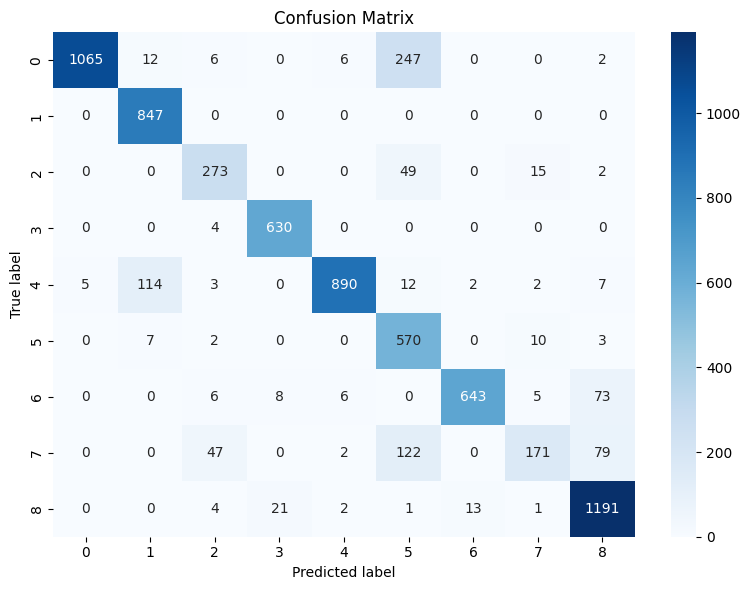

              precision    recall  f1-score   support

           0      0.995     0.796     0.885      1338
           1      0.864     1.000     0.927       847
           2      0.791     0.805     0.798       339
           3      0.956     0.994     0.974       634
           4      0.982     0.860     0.917      1035
           5      0.569     0.963     0.716       592
           6      0.977     0.868     0.919       741
           7      0.838     0.406     0.547       421
           8      0.878     0.966     0.920      1233

    accuracy                          0.875      7180
   macro avg      0.872     0.851     0.845      7180
weighted avg      0.898     0.875     0.874      7180



In [35]:
model.eval()

all_preds = []
all_targets = []

with torch.inference_mode():
    for X, y in test_loader:
        y = y.squeeze().long()

        X = X.to(device)
        y = y.to(device)

        logits = model(X)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

y_true = all_targets
y_pred = all_preds

cm_metric = ConfusionMatrix(task="multiclass", num_classes=len(CLASS_NAMES))
cm_tensor = cm_metric(preds=y_pred, target=y_true).numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_tensor,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

print(classification_report(all_targets, all_preds, digits=3))

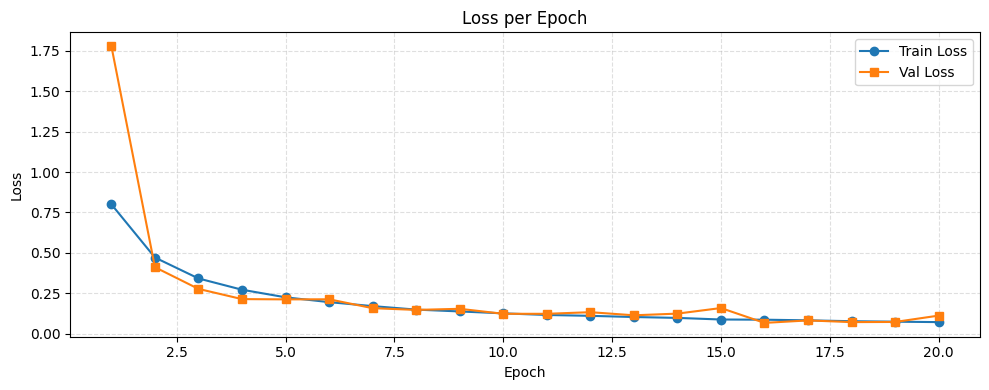

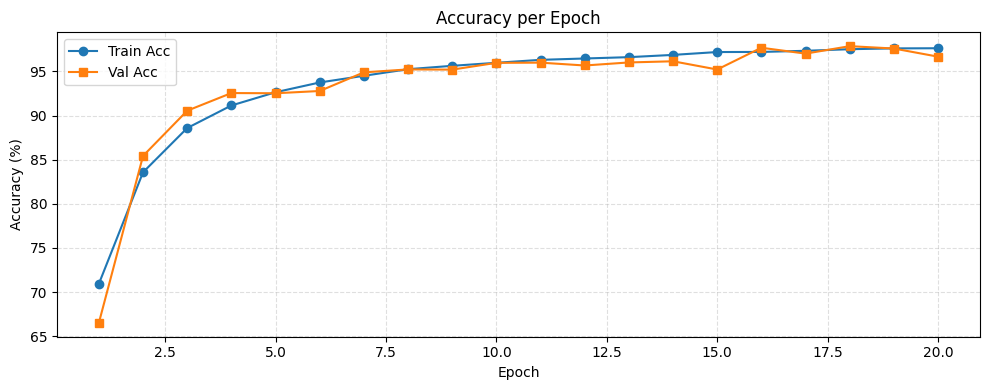

In [34]:
epochs = np.arange(1, len(epoch_train_loss) + 1)

# Loss pro Epoche
plt.figure(figsize=(10,4))
plt.plot(epochs, epoch_train_loss, label="Train Loss", marker="o")
plt.plot(epochs, epoch_val_loss,   label="Val Loss",   marker="s")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss per Epoch")
plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.tight_layout()
plt.show()

# Accuracy pro Epoche
plt.figure(figsize=(10,4))
plt.plot(epochs, epoch_train_acc, label="Train Acc", marker="o")
plt.plot(epochs, epoch_val_acc,   label="Val Acc",   marker="s")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy per Epoch")
plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.tight_layout()
plt.show()